In [1]:
import numpy as np
from astropy.coordinates import EarthLocation, get_moon, get_sun
from lsst.sims.downtimeModel import ScheduledDowntimeData, UnscheduledDowntimeData
from astropy.time import Time
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd

In [2]:
# Swiped from astroplan:  https://github.com/astropy/astroplan/blob/master/astroplan/moon.py
def moon_phase_angle(time, ephemeris=None):
    """
    Calculate lunar orbital phase in radians.
    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation
    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).
    Returns
    -------
    i : float
        Phase angle of the moon [radians]
    """
    # TODO: cache these sun/moon SkyCoord objects

    sun = get_sun(time)
    moon = get_moon(time, ephemeris=ephemeris)
    elongation = sun.separation(moon)
    return np.arctan2(sun.distance*np.sin(elongation),
                      moon.distance - sun.distance*np.cos(elongation))


def moon_illumination(time, ephemeris=None):
    """
    Calculate fraction of the moon illuminated.
    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation
    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).
    Returns
    -------
    k : float
        Fraction of moon illuminated
    """
    i = moon_phase_angle(time, ephemeris=ephemeris)
    k = (1 + np.cos(i))/2.0
    return k.value


Mean lunar illumination in downtime =  0.5203896174459446


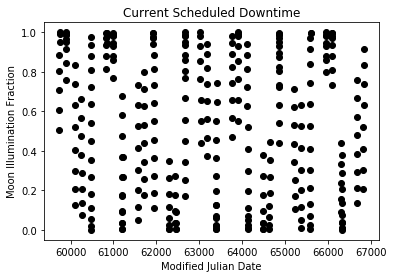

In [3]:
# What we get now

mjd_start = 59853.5
mjd_start_time = Time(mjd_start, format='mjd')
sched_downtime_data = ScheduledDowntimeData(mjd_start_time)
sched_downtimes = sched_downtime_data()

down_starts = []
down_ends = []

mjd_down = []

for dt in sched_downtimes:
    down_starts.append(dt['start'].mjd)
    down_ends.append(dt['end'].mjd)

mean_illums = []
for ds, de in zip(down_starts, down_ends):
    mjd_down.extend(np.arange(ds,de+1, 1).tolist())
    temp_time = Time(np.arange(ds,de+1, 1), format='mjd')
    mean_illums.append(np.mean(moon_illumination(temp_time)))
    
times = Time(mjd_down, format='mjd')
moon_illum = moon_illumination(times)

plt.plot(times.mjd, moon_illum, 'ko')
plt.xlabel('Modified Julian Date')
plt.ylabel('Moon Illumination Fraction')
plt.title('Current Scheduled Downtime')
print('Mean lunar illumination in downtime = ', np.mean(moon_illum))
df = pd.DataFrame()
df['start_orig'] = down_starts
df['end_orig'] = down_ends
df['mean_ill_orig'] = mean_illums

Mean lunar illumination in downtime =  0.8506317411897075


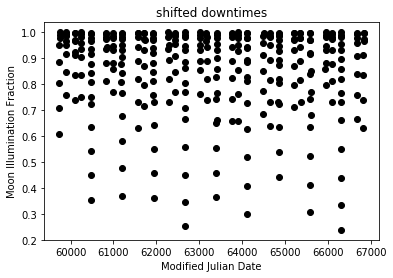

In [4]:
mjd_start = 59853.5
mjd_start_time = Time(mjd_start, format='mjd')
sched_downtime_data = ScheduledDowntimeData(mjd_start_time)
sched_downtimes = sched_downtime_data()

down_starts = []
down_ends = []

mjd_down = []

for dt in sched_downtimes:
    dt_mid = np.round((dt['end'].mjd-dt['start'].mjd)/2.) + dt['start'].mjd
    mjds = np.arange(dt['start'].mjd-20., dt['end'].mjd+20.+1, 1.)
    times = Time(mjds, format='mjd')
    moon_illums = moon_illumination(times)
    full = np.where(moon_illums > 0.93)[0]
    time_shifts = mjds[full] - dt_mid
    best_shift = time_shifts[np.min(np.where(np.abs(time_shifts) == np.min(np.abs(time_shifts)))[0])]
    down_starts.append(dt['start'].mjd + best_shift)
    down_ends.append(dt['end'].mjd + best_shift)

mean_illums = []
for ds, de in zip(down_starts, down_ends):
    mjd_down.extend(np.arange(ds,de+1, 1).tolist())
    temp_time = Time(np.arange(ds,de+1, 1), format='mjd')
    mean_illums.append(np.mean(moon_illumination(temp_time)))
    
times = Time(mjd_down, format='mjd')
moon_illum = moon_illumination(times)

plt.plot(times.mjd, moon_illum, 'ko')
plt.xlabel('Modified Julian Date')
plt.ylabel('Moon Illumination Fraction')
plt.title('shifted downtimes')
print('Mean lunar illumination in downtime = ', np.mean(moon_illum))

df['start_shifted'] = down_starts
df['end_shifted'] = down_ends
df['mean_ill_shifted'] = mean_illums

In [5]:
df['days_shifted'] = df['start_orig'] - df['start_shifted']
df

,start_orig,end_orig,mean_ill_orig,start_shifted,end_shifted,mean_ill_shifted,days_shifted
0,59737.66,59744.66,0.806674,59738.66,59745.66,0.865721,-1.0
1,59886.66,59893.66,0.926570,59886.66,59893.66,0.926570,0.0
2,60102.66,60109.66,0.470764,60096.66,60103.66,0.917955,6.0
3,60251.66,60258.66,0.349023,60243.66,60250.66,0.919489,8.0
4,60467.66,60481.66,0.462616,60473.66,60487.66,0.784279,-6.0
5,60832.66,60839.66,0.939415,60832.66,60839.66,0.939415,0.0
6,60981.66,60988.66,0.918994,60981.66,60988.66,0.918994,0.0
7,61197.66,61211.66,0.241653,61186.66,61200.66,0.808465,11.0
8,61562.66,61569.66,0.370714,61568.66,61575.66,0.873745,-6.0
9,61711.66,61718.66,0.485836,61717.66,61724.66,0.905562,-6.0
